In [1]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import struct
import numpy as np
%matplotlib inline

#import mpld3
#mpld3.enable_notebook()

In [2]:
def calcPSNR(ref, img):
    shape = img.shape
    imgVec = img.reshape((shape[0] * shape[1] * shape[2]))
    refVec = ref.reshape((shape[0] * shape[1] * shape[2]))
    mse = np.mean(np.square(np.subtract(refVec, imgVec)))
    return (20 * np.log10(np.max(refVec)) - 10 * np.log10(mse), mse)

In [3]:
from __future__ import print_function

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
from keras.preprocessing.image import ImageDataGenerator

from model import seg,unet,DMCNN
import numpy as np
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,TerminateOnNaN
from scipy import misc
from keras.callbacks import TensorBoard
import math
import cv2 as cv
import tools.img2raw as im

import tensorflow as tf

#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
#  try:
#    tf.config.experimental.set_virtual_device_configuration(
#        gpus[0],
#        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=256)])
#    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#  except RuntimeError as e:
#    # Virtual devices must be set before GPUs have been initialized
#    print(e)

model = DMCNN.dmcnnvd(128,128,3)
model.load_weights("weight/dmcnn-vd-0.0001-75000-128-2019-11-19-17-12-59.h5")


Using TensorFlow backend.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

(3, 3, 3, 64)


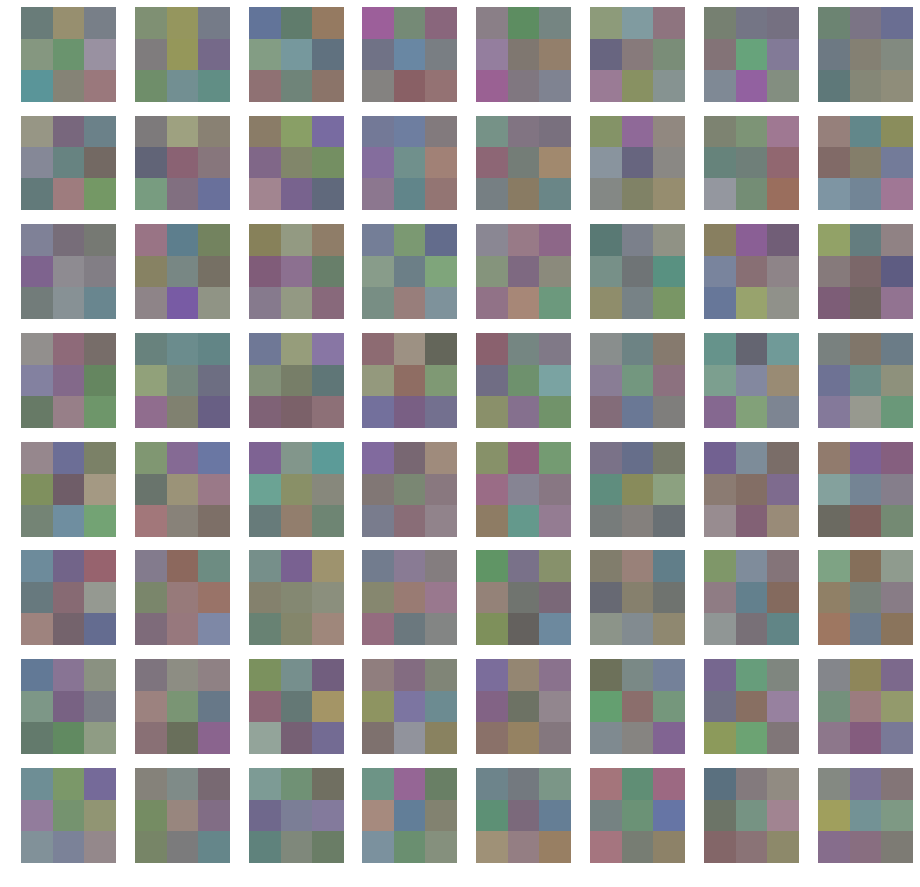

In [4]:
weights = model.layers[1].get_weights()[0]

print(weights.shape)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

f, axarr = plt.subplots(8, 8, sharex=True)
f.subplots_adjust(hspace=0)
# f.subplots_adjust(vspace=0)
f.set_figheight(16)
f.set_figwidth(16)

for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(sigmoid(weights[:,:,:,i * 8 + j]), interpolation='nearest')
        axarr[i,j].set_axis_off()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


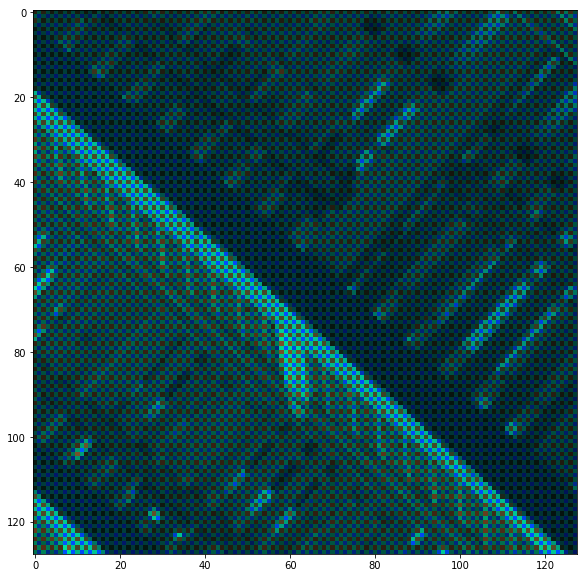

In [5]:
img0 = im.readBinImg("39314.bin")
img1 = im.readBinImg("43705.bin")
img2 = im.readBinImg("56057.bin")

img_result = model.predict(np.array([img0, img1, img2]))

plt.figure(figsize = (10,10))
plt.imshow(img0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


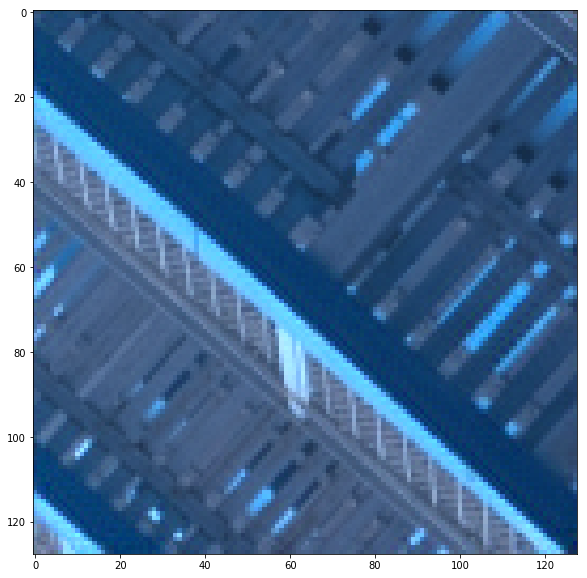

In [6]:
plt.figure(figsize = (10,10))
plt.imshow(img_result[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


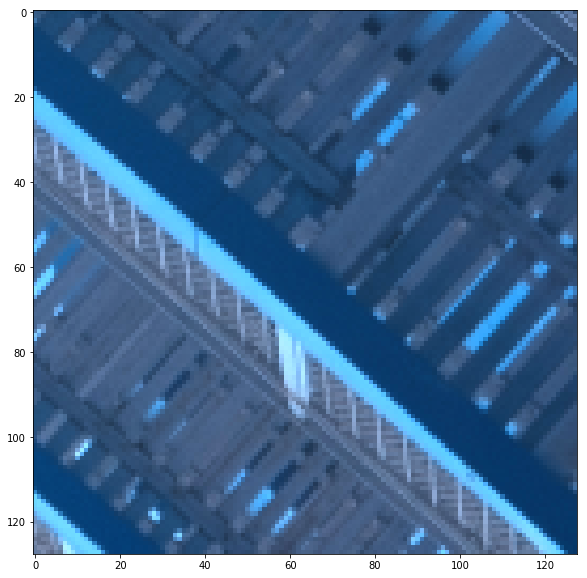

In [7]:
imref0 = im.readBinImg("39314ref.bin")

plt.figure(figsize = (10,10))
plt.imshow(imref0)

# masked = np.any(imref0 > [1.0, 1.0, 1.0], axis=-1) ^ np.any(img_result[0] > [1.0, 1.0, 1.0], axis=-1)
# plt.imshow(masked)

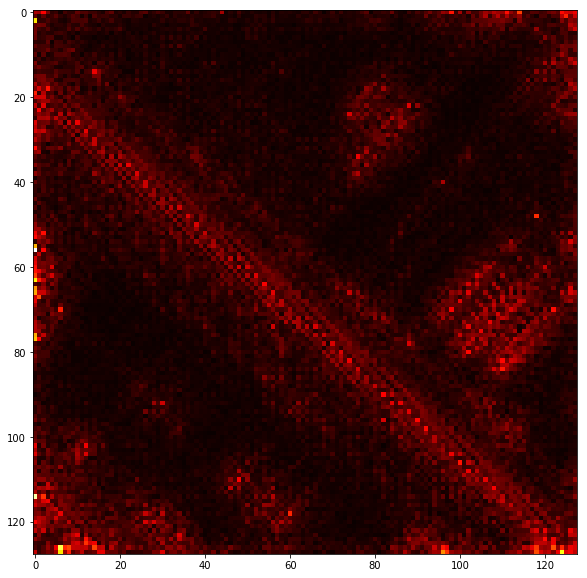

In [8]:
imdiff = np.abs(np.subtract(imref0, img_result[0]))

lum_img = (imdiff[:,:,0] + imdiff[:,:,1] + imdiff[:,:,2])

plt.figure(figsize = (10,10))
imgplot = plt.imshow(lum_img)

imgplot.set_cmap('hot') 

In [9]:
snr = calcPSNR(imref0, img_result[0])
print("PSNR=", snr[0], "dB  MSE=", snr[1])

PSNR= 38.1639273465 dB  MSE= 0.000234803


In [10]:
msssim = 1.0 - tf.image.ssim_multiscale(imref0, img_result[0], 2.0, filter_size=8)

print(msssim)

L1 = np.mean(np.abs(imref0 - img_result[0]))

print(L1)

tf.Tensor(0.00122863, shape=(), dtype=float32)
0.00943264


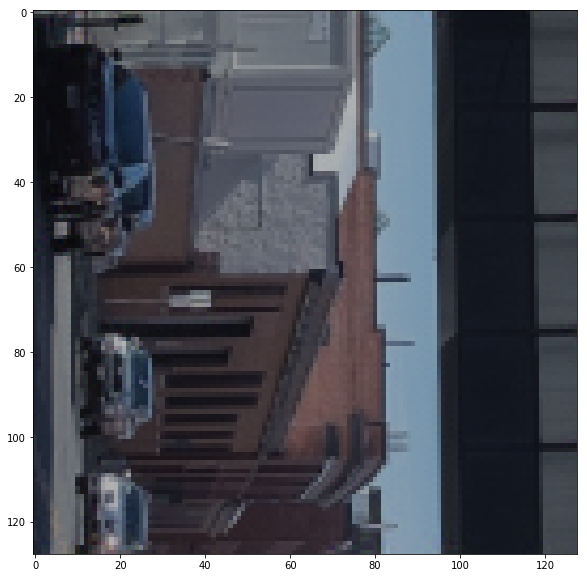

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(img_result[1])

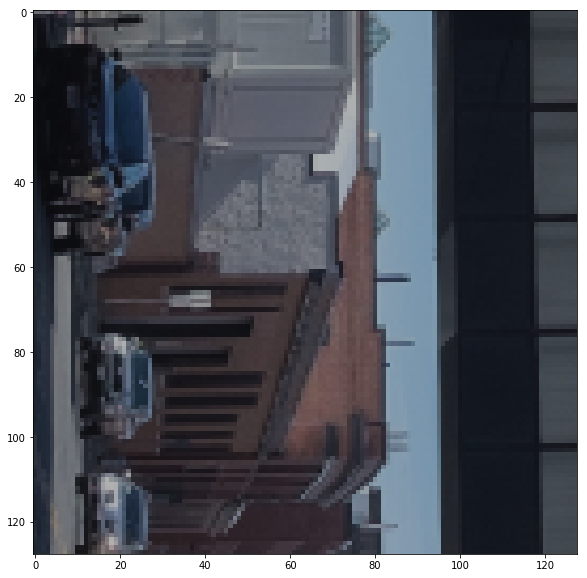

In [12]:
imref1 = im.readBinImg("43705ref.bin")

plt.figure(figsize = (10,10))
plt.imshow(imref1)

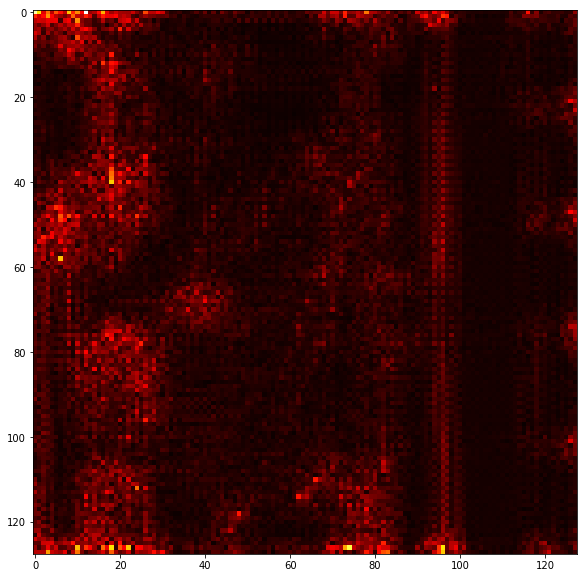

In [13]:
imdiff = np.abs(np.subtract(imref1, img_result[1]))

lum_img = (imdiff[:,:,0] + imdiff[:,:,1] + imdiff[:,:,2])

plt.figure(figsize = (10,10))
imgplot = plt.imshow(lum_img)

imgplot.set_cmap('hot') 

In [14]:
snr = calcPSNR(imref1, img_result[1])
print("PSNR=", snr[0], "dB  MSE=", snr[1])

PSNR= 40.3497955203 dB  MSE= 4.45703e-05


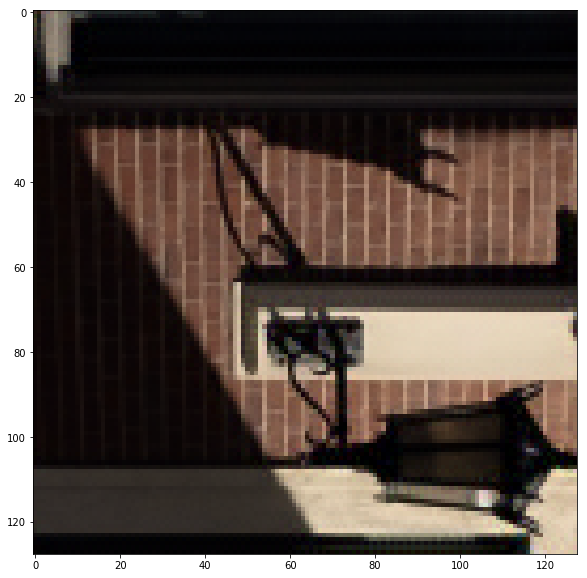

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(img_result[2])

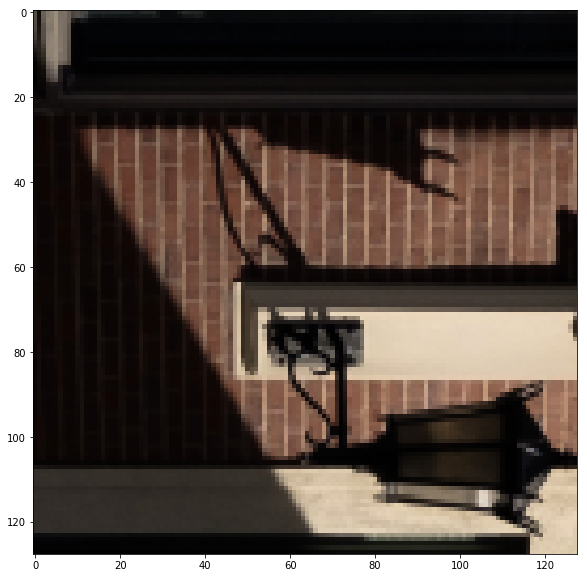

In [16]:
imref2 = im.readBinImg("56057ref.bin")

plt.figure(figsize = (10,10))
plt.imshow(imref2)

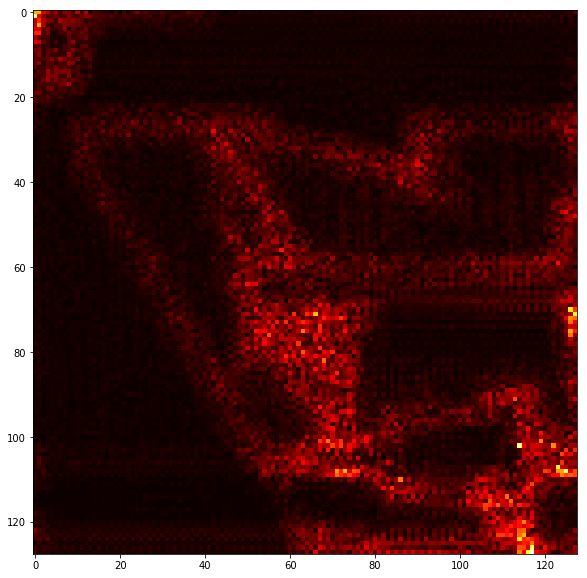

In [17]:
imdiff = np.abs(np.subtract(imref2, img_result[2]))

lum_img = (imdiff[:,:,0] + imdiff[:,:,1] + imdiff[:,:,2])

plt.figure(figsize = (10,10))
imgplot = plt.imshow(lum_img)

imgplot.set_cmap('hot') 

In [18]:
snr = calcPSNR(imref2, img_result[2])
print("PSNR=", snr[0], "dB  MSE=", snr[1])

PSNR= 37.0769035816 dB  MSE= 0.0001683
